In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Testování hypotéz

In [2]:
from scipy.stats import norm
N = norm(loc=0, scale=1)

Definujeme normální rozdělení
$$\cal{N}(\mu=0, \sigma^2=1)$$

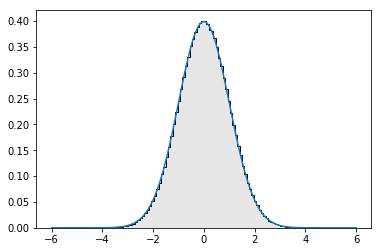

In [3]:
X = N.rvs(size=1000000)
counts, bins, plot = plt.hist(X, bins=100, histtype="stepfilled", normed=True, color=".9", edgecolor="k")
x = np.linspace(-6, 6, 200)
plt.plot(x, N.pdf(x))

Ověříme metodou Monte Carlo nulovou hypotézu, že jde skutečně o $\cal{N}(0,1)$. Jako kontrolní statistiku použijeme střední hodnotu z $n$ vzorků:
$$\hat\mu_n = \bar x_i = \frac{1}{n}\sum_{i=1}^n x_i$$
V nulové hypotéze platí
$${\rm Var}[\mu_n] = \frac{1}{n}{\rm Var}[x]$$
$$\mu_n \sim \cal{N}(0, \sigma^2/n)$$
a oboustranné kvantily pro hladinu signifikance $\alpha$ lze určit z CDF normálního rozdělení. Požadujeme tedy:
$${\rm CDF}[{\cal N}(0, \sigma^2/n)](\alpha/2) < \hat\mu_n < {\rm CDF}[{\cal N}(0, \sigma^2/n)](1-\alpha/2)$$
nebo
$${\rm CDF}[{\cal N}(0, \sigma^2)](\alpha/2) < \hat\mu_n\sqrt{n} < {\rm CDF}[{\cal N}(0, \sigma^2)](1-\alpha/2)$$

In [4]:
np.random.seed(12)
nsampl = 2
X = N.rvs(size=nsampl)
S = np.mean(X)*np.sqrt(nsampl) # mean(X)*sqrt(n)

alpha = 0.01
k1 = N.ppf(alpha/2)
k2 = N.ppf(1-alpha/2)
print("k1 = %.3f" % k1)
print("S  = %.3f" % S)
print("k2 = %.3f" % k2)
print("k1 < S < k2: %s" % ("OK" if k1 < S and S < k2 else "FAIL"))

k1 = -2.576
S  = -0.147
k2 = 2.576
k1 < S < k2: OK


Text(0.5,0,'num. samples')

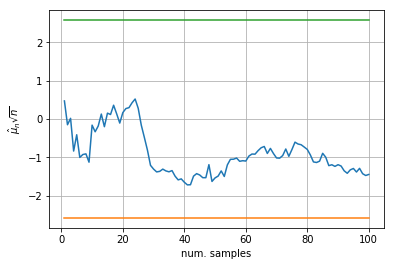

In [5]:
np.random.seed(12)
nmax = 100
X = N.rvs(size=(nmax))
n = np.arange(1,len(X)+1)
S = np.cumsum(X)/np.sqrt(n)
plt.plot(n, S)

alpha = 0.01
k1 = N.ppf(alpha/2)
k2 = N.ppf(1-alpha/2)
plt.plot(n, k1+0*n)
plt.plot(n, k2+0*n)
plt.grid()
plt.ylabel(r"$\hat\mu_n\sqrt{n}$")
plt.xlabel("num. samples")
#plt.gca().set_xscale("log")

Test má správnou hladinu signifikance pokud je proveden pouze jednou.
Opakovaným testováním lze vždy dostat signifikantní výsledek! Případně je nutné provást korekci
vypočtené signifikace - viz např https://en.wikipedia.org/wiki/Multiple_comparisons_problem

Text(0.5,0,'num. samples')

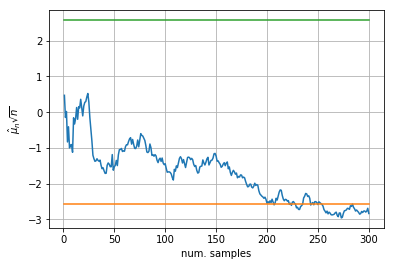

In [8]:
np.random.seed(12)
#nmax = 1030000
nmax = 300
X = N.rvs(size=(nmax))
n = np.arange(1,len(X)+1)
S = np.cumsum(X)/np.sqrt(n)
plt.plot(n, S)

alpha = 0.01
k1 = N.ppf(alpha/2)
k2 = N.ppf(1-alpha/2)
plt.plot(n, k1+0*n)
plt.plot(n, k2+0*n)
plt.grid()
plt.ylabel(r"$\hat\mu_n\sqrt{n}$")
plt.xlabel("num. samples")
#plt.gca().set_xscale("log")

### Testování hypotéz - neznámé rozdělení testovací statistiky
Příklad: hod kostkou

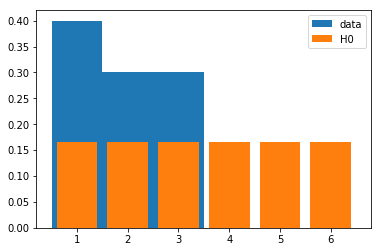

In [24]:
# ziskane hodnoty:
sample = [1, 1, 1, 1, 2, 2, 2, 3, 3, 3]
vals = np.arange(1, 7)
bins=np.arange(7)+0.5
cts, _, _ = plt.hist(sample, bins=bins, normed=True, label="data")
cts0 = np.ones(6)/6
plt.bar(vals, cts0, color="C1", label="H0")
plt.legend()

Je ta kostka vyvážená? Můžeme použít chi-square test, ale ten je pouze pro velké počty vzorků. Nebo Kolmogorov-Smirnov, ale ten je zase pouze pro spojité distribuce :-(. Obrázek níže ilustruje výpočet Kolmogorovovy-Smirnovovy statistiky.

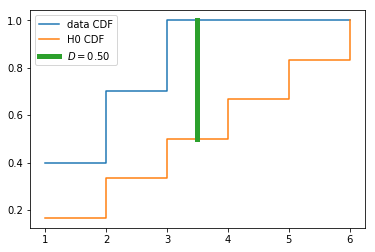

In [25]:
cdf = np.cumsum(cts)
cdf0 = np.cumsum(cts0)
plt.step(vals, cdf, where="post", label="data CDF")
plt.step(vals, cdf0, where="post", label="H0 CDF")
iD = np.argmax(np.abs(cdf-cdf0))
D = np.abs(cdf-cdf0)[iD]

plt.plot([vals[iD]+.5, vals[iD]+.5], [cdf[iD], cdf0[iD]], label=r"$D=%.2f$"%D, lw=5)
plt.legend()

Nebo můžeme provést MC simulaci vyvážené kostky, vypočíst rozdělení testovací statistiky a porovnat s měřením:

In [26]:
nsampl = 10000
MCsamples = np.random.randint(1, 7, (len(sample), nsampl))

In [27]:
MC_cts = np.apply_along_axis(lambda a: np.histogram(a, bins=bins, normed=True)[0], 0, MCsamples)

In [28]:
MC_cdf = np.cumsum(MC_cts, axis=0)

In [29]:
Ds = np.max(np.abs(MC_cdf - cdf0[:,np.newaxis]), axis=0)

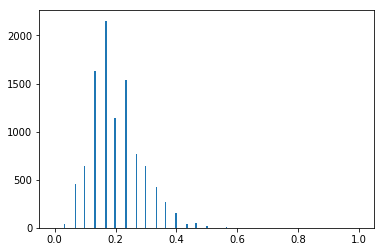

In [30]:
_, _, _ = plt.hist(Ds, bins=np.linspace(0, 1, 200))

A dostaneme pravděpodobnost, že testovací statistika bude 

In [31]:
len(Ds[Ds>=D])/len(Ds)

0.0031

## Bootstrap - odhad intervalů spolehlivosti

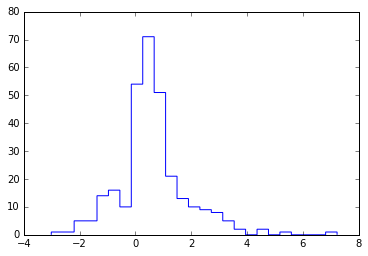

In [30]:
np.random.seed(12)
x = np.concatenate([np.random.exponential(size=200), np.random.normal(size=100)])
plt.hist(x, 25, histtype='step');

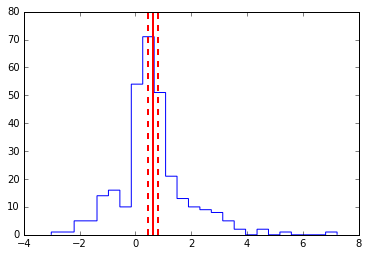

In [34]:
n = len(x)
reps = 10000
xb = np.random.choice(x, (n, reps), replace=True)
mb = xb.mean(axis=0)
mb.sort()

plt.hist(x, 25, histtype='step');
plt.axvline(np.mean(x), c="r", lw=2)
alpha = 0.01
perc = np.percentile(mb, [100*alpha/2, 100*(1-alpha/2)])
plt.axvline(perc[0], c="r", lw=2, ls="--")
plt.axvline(perc[1], c="r", lw=2, ls="--")


In [23]:
xb = np.random.choice?

In [ ]:
xb = np.random.choice